# Diffraction Ring Based Detector Geometry Calibration

This notebook serves demonstrates how to use ipython based widgets to create a starting geometry from Power Based ring diffraction pattern.

In [2]:
%matplotlib notebook
#This important for interactive plots 
import os
import warnings
import sys

from matplotlib import pyplot as plt
import matplotlib.patches as patches

sys.path.insert(0, os.path.join('../'))

warnings.filterwarnings('ignore')
import numpy as np

import karabo_data as kd
from geoAssembler import CalibrateNb as Calibrate
from geoAssembler.geometry import AGIPD_1MGeometry

## Get a run dataset with ring pattern

The example *instrument* has a some runs with interesting data. Run 273 contains data with diffraction patterns from Lithium Titanium. First open this run with karabo-data and read the data


In [7]:
run_dir = '/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0273'
run = kd.RunDirectory(run_dir)
run.info()

# of trains:    156
Duration:       0:00:15.500000
First train ID: 198425241
Last train ID:  198425396

16 detector modules (SPB_DET_AGIPD1M-1)
  e.g. module SPB_DET_AGIPD1M-1 0 : 512 x 128 pixels
  176 frames per train, 27456 total frames

0 instrument sources (excluding detectors):

0 control sources:



## Define some parameters:
Detector distance to the sample, Beam wave length are certainly helpful variables that should be defined in the geometry file. Let's define those parameters:

In [18]:
clen = 0.119 #Detector distance in m
energy = 10235 #Photon energy in eV I believe

In [20]:
#Now construct the header of the geometry file from those properties
header = """data = /entry_1/data_1/data
;mask = /entry_1/data_1/mask

mask_good = 0x0
mask_bad = 0xffff

adu_per_eV = 0.0075  ; no idea
clen = {}  ; Camera length, aka detector distance
photon_energy = {} ;""".format(clen, energy)

## Read the train data

In [8]:
tId, train_data = run.train_from_index(3)
tId

198425244

Use the ```stack_detector_data``` to create a big with all pulses for the selected train data. 

In [6]:
train_array = kd.stack_detector_data(train_data, 'image.data', only='DET')
train_array.shape

(176, 16, 512, 128)

Let's apply the ```sum``` function over a train rather than selecting single pulses. This can help to get a clearer signal, if necessary.

In [9]:
data_array = np.sum(np.clip(train_array, 0, 2000), axis=0)

### Start the geometry calibration with
First lets assume that we have no prior knowledge about the detector geometry. We naively just assume that all modules equally spaced with 29px distance to each other.

<IPython.core.display.Javascript object>


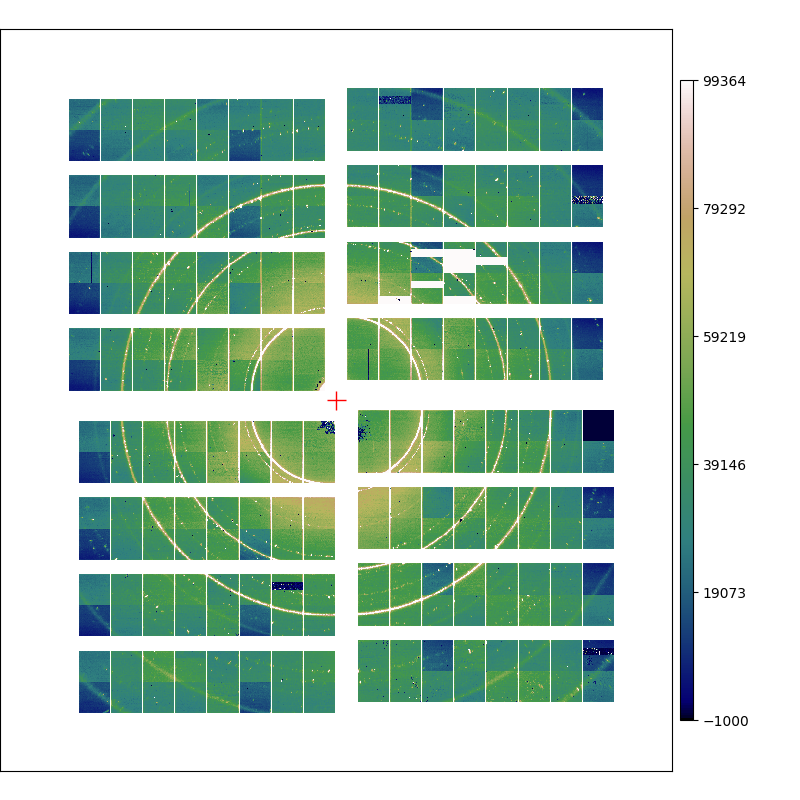

In [13]:
from geoAssembler import CalibrateNb as Calibrate
C =  Calibrate(data_array, geometry=None, vmin=0, vmax=1e5, figsize=(8,8))

Helper circles that guide the quadrant movement can be added by pushing the *Add circle* button. There can be multiple at a time. If there are different circles present, individual circles can be selected using the *Sel.* drop down menu. The radius can be adjusted with help of the *Radius* menu.

The quadrants can be moved by selecting a Quadrant from the *Quadrant* menu. The selected quadrant can be moved horizontally and vertically via the *Horizontal* and *Vertical* spin boxes.

The centre of the geometry can be retrieved with the ```centre``` attribute:

In [14]:
C.centre

array([638, 549])

Finally the geometry can be saved by calling ```geom.write_crystfel_geom```. This method gets the output filename and the 'header' that contains information about detector distance and photon energy.

In [21]:
C.geom.write_crystfel_geom('testing.geom', header)

The new geometry file could also be loaded for another round of refinement:

<IPython.core.display.Javascript object>


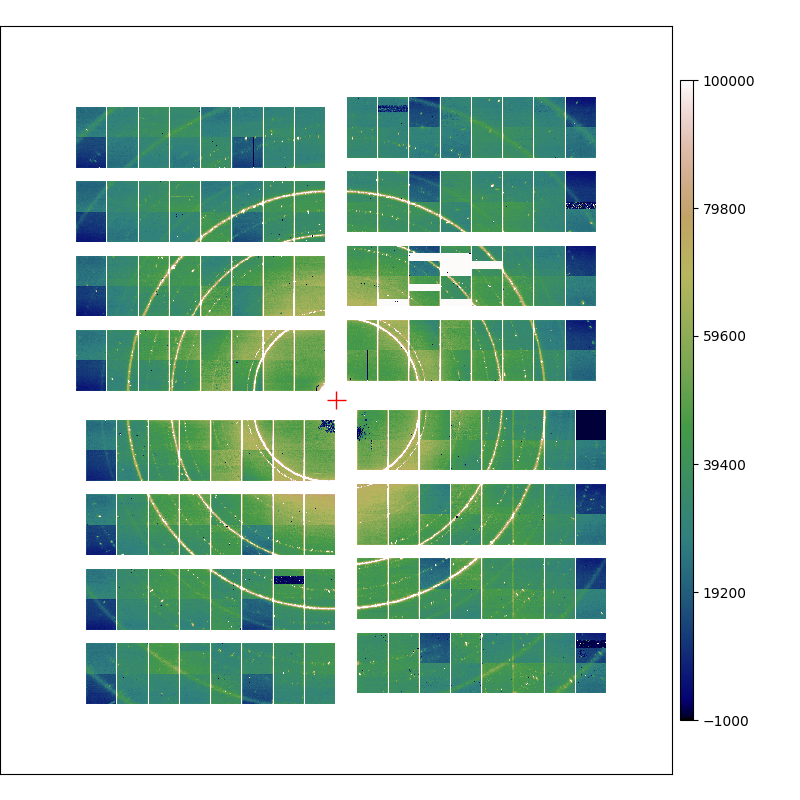

In [22]:
C_new =  Calibrate(data_array, geometry=C.geom, vmin=0, vmax=1e5, figsize=(8,8))